In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
from scipy import stats

In [3]:
from datetime import datetime
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [13]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [14]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [15]:
# reflect an existing database into a new model using automap_base()
Base = automap_base()
# reflect the tables with Base.prepare(), passing in the engine and reflect=True
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found with Base.classes
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [19]:
# Create our Session() and bind it to the engine
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database.
last_measurement_data_point = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = last_measurement_data_point [0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

In [25]:
# Use session.query() to retrieve the date and prcp columns, .filter() by the date you calculated above, and selecting .all() results
last_year_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= date_year_ago).all()



In [26]:
# Save the query results as a Pandas DataFrame() and set the index to the date column
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(last_year_data, columns = ['date', 'prcp'])
#drop nulls
climate_df = climate_df.dropna(how="any")
#set index
climate_df = climate_df.set_index("date")

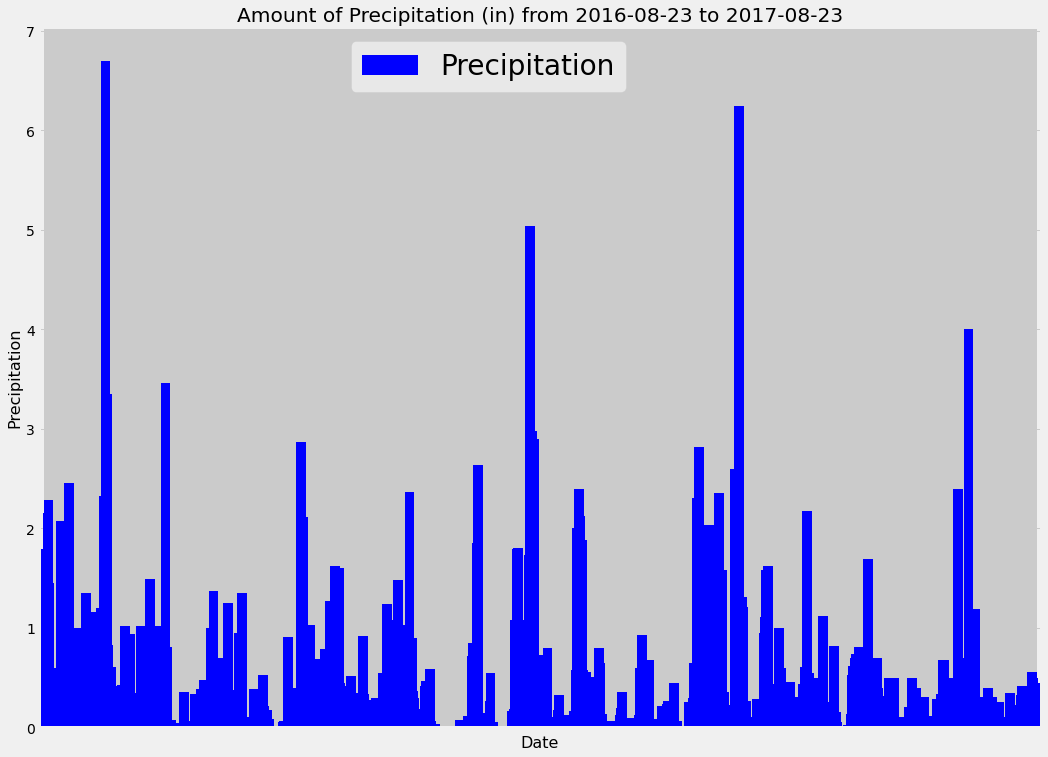

In [28]:
# Sort the dataframe by date
climate_df = climate_df.sort_values(by=['date'])
climate_df.head(100)
# Use Pandas Plotting with Matplotlib to plot the data

ax= climate_df.plot.bar(figsize=(16,12), width=20, color='blue')
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Precipitation", fontsize=16)
ax.set_xticklabels([])
ax.set_title(f"Amount of Precipitation (in) from {date_year_ago} to {latest_date}")
plt.legend(['Precipitation'], fontsize = 28)
ax.get_legend().set_bbox_to_anchor((0.6, 1))

plt.savefig("Images/CLIMATE.png")
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = climate_df["prcp"].describe()
stats_df = pd.DataFrame(stats)
stats_df.rename(columns = {"prcp": "Precipitation"})

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


##### Design a query to show how many stations are available in this dataset


In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. Hint: session.query() the station column in the Station table
session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).\
order_by(func.count(measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
most_active_station=session.query(measurement.station).group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).first()
most_active_station_id = most_active_station[0]
most_active_station_id

'USC00519281'

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(measurement.date).\
order_by(measurement.date.desc()).\
filter(measurement.station == most_active_station_id).first()

latest_date = temp_observation[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

last_year_data = session.query(measurement.date, measurement.tobs).\
filter(measurement.station == most_active_station_id).\
filter(measurement.date >= date_year_ago).all()

last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])

last_year_data_df

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


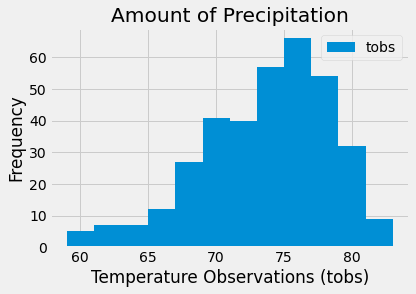

In [35]:
#Histogram
df = pd.DataFrame(last_year_data_df, columns=['tobs'])
df.plot.hist(bins=12)
plt.title(f"Amount of Precipitation")
plt.tight_layout()
plt.xlabel('Temperature Observations (tobs)')
plt.savefig("Images/Frequency.png")
plt.show()

## Bonus Challenge Assignment

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (session.query(func.min(measurement.tobs), 
                         func.avg(measurement.tobs), 
                         func.max(measurement.tobs))
                    .filter(measurement.date >= start_date)
                    .filter(measurement.date <= end_date)
                    .all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = dt.date(2017, 5, 10)
trip_end_date = dt.date(2017, 5, 16)
print(calc_temps(trip_start_date, trip_end_date))
temps_list = calc_temps(trip_start_date, trip_end_date)

[(70.0, 75.38461538461539, 79.0)]


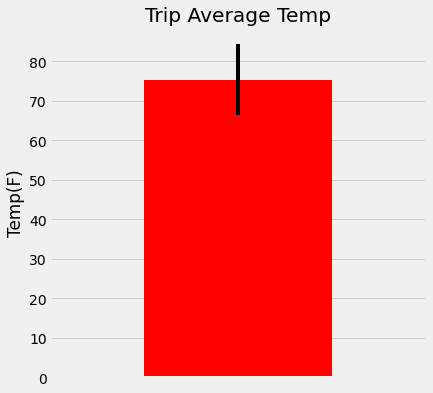

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(temps_list, columns=["t_min", "t_avg", "t_max"])

# plot the average temp 
plt.figure(figsize=(6,6))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="red")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)


# Save the plot

plt.savefig("Images/avg_temp.png")
plt.show()

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [measurement.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]
total_rainfall_per_weather_station = session.query(*sel).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= trip_start_date).\
    filter(measurement.date <= trip_end_date).\
    group_by(measurement.station).\
    order_by(func.sum(measurement.prcp).desc()).all()
    
rainfall_df = pd.DataFrame(total_rainfall_per_weather_station, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Sum/Total Precipitation"])

rainfall_df


,Station,Name,Latitude,Longitude,Elevation,Sum/Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.09
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.75
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.30
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.12
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.07
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05


In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    return (session.query(func.min(measurement.tobs), 
                          func.avg(measurement.tobs), 
                          func.max(measurement.tobs))
                   .filter(func.strftime("%m-%d", measurement.date) == date)
                   .all())
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime.strftime(trip_start_date, "%m-%d")
end = dt.datetime.strftime(trip_end_date, "%m-%d")

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start, "%m-%d")
end = dt.datetime.strptime(end, "%m-%d")

#use the start and end to create range 
date_array = (start + dt.timedelta(days=x) for x in range(0, ((end-start).days)+1))

# Stip off the year and save a list of %m-%d strings
date_list = []
for date_object in date_array:
    string_date = date_object.strftime("%m-%d")
    date_list.append(string_date)

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list = []
for date in date_list:
    daily_normals_list.append(daily_normals(date))

min_temp_list = []
avg_temp_list = []
max_temp_list = []
print(daily_normals_list)
for daily_normals_item in daily_normals_list:
    for min_temp, avg_temp, max_temp in daily_normals_item:
        min_temp_list.append(min_temp)
        avg_temp_list.append(avg_temp)
        max_temp_list.append(max_temp)

[[(64.0, 73.3157894736842, 78.0)], [(65.0, 73.61111111111111, 79.0)], [(65.0, 73.13793103448276, 79.0)], [(67.0, 73.14285714285714, 79.0)], [(63.0, 73.89285714285714, 80.0)], [(63.0, 73.69090909090909, 79.0)], [(68.0, 74.37931034482759, 80.0)]]


In [48]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame({
    "trip_dates": date_list,
    "tmin": min_temp_list,
    "tavg": avg_temp_list,
    "tmax": max_temp_list
})
daily_normals_df = daily_normals_df.set_index("trip_dates")
daily_normals_df

,tmin,tavg,tmax
trip_dates,,,
05-10,64.0,73.315789,78.0
05-11,65.0,73.611111,79.0
05-12,65.0,73.137931,79.0
05-13,67.0,73.142857,79.0
05-14,63.0,73.892857,80.0
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0


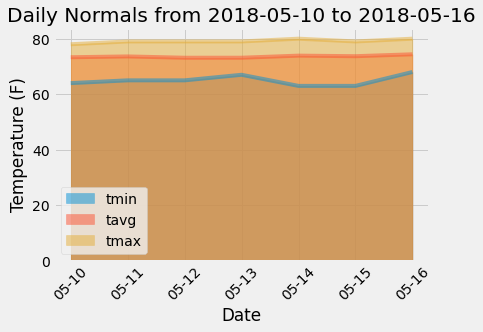

In [49]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked=False)
trip_start = trip_start_date.replace(year = trip_start_date.year + 1)
trip_end = trip_end_date.replace(year = trip_end_date.year + 1)
ax.set_title(f"Daily Normals from {trip_start} to {trip_end}")
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")
plt.savefig("Images/daily_normals.png")
plt.show()